# Лабораторна робота №3
## Класифікація твітів за тональністю з використанням Word2Vec

Датасет: COVID-19 NLP Text Classification

Завдання: класифікація твітів на Positive, Negative, Other

## 1. Імпорт бібліотек

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## 2. Завантаження та огляд даних

In [3]:
df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')

print(f"Розмір датасету: {df.shape}")
print(f"\nПерші рядки:")
df.head()

Розмір датасету: (41157, 6)

Перші рядки:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
print("Інформація про датасет:")
df.info()

Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Розподіл класів:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


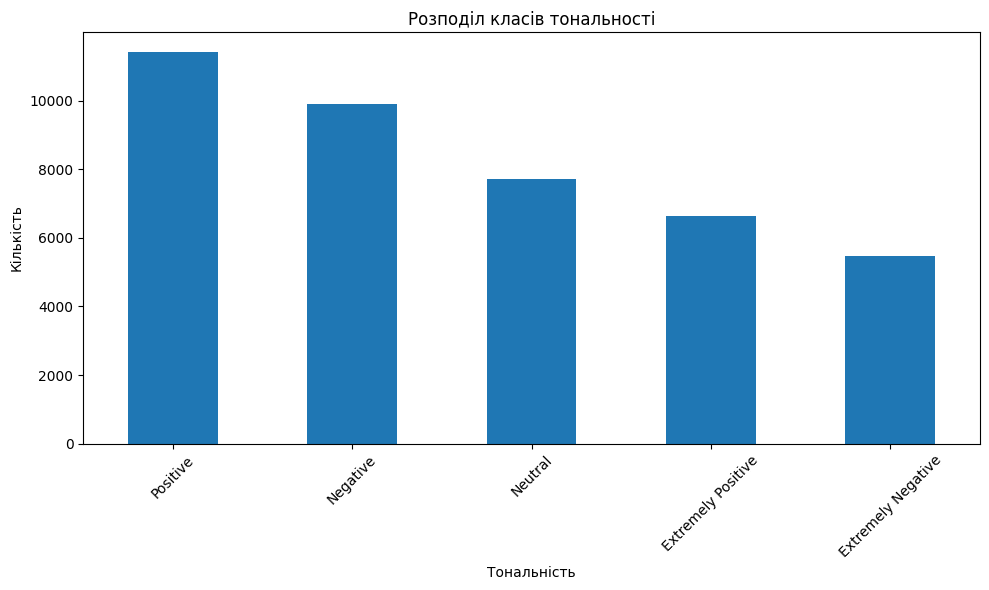

In [5]:
print("Розподіл класів:")
print(df['Sentiment'].value_counts())

df['Sentiment'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title('Розподіл класів тональності')
plt.xlabel('Тональність')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Попередня обробка тексту

In [6]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return []
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

print("Обробка текстів...")
df['processed_tokens'] = df['OriginalTweet'].apply(preprocess_text)

print("\nПриклад обробки:")
print(f"Оригінал: {df['OriginalTweet'].iloc[0][:100]}...")
print(f"Оброблено: {df['processed_tokens'].iloc[0][:10]}")

Обробка текстів...

Приклад обробки:
Оригінал: @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co...
Оброблено: []


## 4. Навчання Word2Vec моделі

In [7]:
sentences = df['processed_tokens'].tolist()
sentences = [s for s in sentences if len(s) > 0]

print("Навчання Word2Vec моделі...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    seed=42
)

print(f"\nРозмір словника: {len(w2v_model.wv)}")
print(f"Розмір вектора: {w2v_model.wv.vector_size}")

Навчання Word2Vec моделі...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'



Розмір словника: 20459
Розмір вектора: 100


In [8]:
def get_tweet_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(vectors, axis=0)

print("Створення векторних представлень твітів...")
df['tweet_vector'] = df['processed_tokens'].apply(lambda x: get_tweet_vector(x, w2v_model))

X = np.array(df['tweet_vector'].tolist())
print(f"Форма матриці ознак: {X.shape}")

Створення векторних представлень твітів...
Форма матриці ознак: (41157, 100)


## 5. Підготовка цільової змінної

In [9]:
label_mapping = {
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Other',
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
}

df['Label'] = df['Sentiment'].map(label_mapping)

print("Розподіл після групування:")
print(df['Label'].value_counts())

le = LabelEncoder()
y = le.fit_transform(df['Label'])

print(f"\nКласи: {le.classes_}")

Розподіл після групування:
Label
Positive    18046
Negative    15398
Other        7713
Name: count, dtype: int64

Класи: ['Negative' 'Other' 'Positive']


## 6. Розділення на тренувальну та тестову вибірки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

Розмір тренувальної вибірки: (32925, 100)
Розмір тестової вибірки: (8232, 100)


## 7. Навчання моделей без PCA

In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

results_no_pca = {}

print("Навчання моделей без PCA...\n")

for name, model in models.items():
    print(f"Навчання {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results_no_pca[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}\n")

Навчання моделей без PCA...

Навчання Logistic Regression...
Accuracy: 0.6226
F1-score: 0.6147

Навчання SVM...
Accuracy: 0.6489
F1-score: 0.6412

Навчання Random Forest...
Accuracy: 0.6244
F1-score: 0.6146

Навчання Naive Bayes...
Accuracy: 0.5245
F1-score: 0.5262



In [12]:
results_df_no_pca = pd.DataFrame({
    'Model': list(results_no_pca.keys()),
    'Accuracy': [r['accuracy'] for r in results_no_pca.values()],
    'Precision': [r['precision'] for r in results_no_pca.values()],
    'Recall': [r['recall'] for r in results_no_pca.values()],
    'F1-score': [r['f1'] for r in results_no_pca.values()]
})

print("Результати без PCA:")
results_df_no_pca

Результати без PCA:


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.622570,0.617786,0.622570,0.614659
1,SVM,0.648931,0.649542,0.648931,0.641178
2,Random Forest,0.624393,0.624921,0.624393,0.614644
3,Naive Bayes,0.524538,0.528755,0.524538,0.526166


## 8. Навчання моделей з PCA

In [13]:
pca_components = [50, 100]
results_with_pca = {}

for n_components in pca_components:
    print(f"\n{'='*60}")
    print(f"PCA з {n_components} компонентами")
    print(f"{'='*60}\n")
    
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print(f"Пояснена дисперсія: {pca.explained_variance_ratio_.sum():.4f}\n")
    
    results_with_pca[n_components] = {}
    
    for name, model in models.items():
        print(f"Навчання {name}...")
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_train_pca, y_train)
        y_pred = model_clone.predict(X_test_pca)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        results_with_pca[n_components][name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'y_pred': y_pred
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-score: {f1:.4f}\n")


PCA з 50 компонентами

Пояснена дисперсія: 0.9866

Навчання Logistic Regression...
Accuracy: 0.5963
F1-score: 0.5864

Навчання SVM...
Accuracy: 0.6410
F1-score: 0.6339

Навчання Random Forest...
Accuracy: 0.6166
F1-score: 0.6039

Навчання Naive Bayes...
Accuracy: 0.5482
F1-score: 0.5492


PCA з 100 компонентами

Пояснена дисперсія: 1.0000

Навчання Logistic Regression...
Accuracy: 0.6217
F1-score: 0.6137

Навчання SVM...
Accuracy: 0.6499
F1-score: 0.6435

Навчання Random Forest...
Accuracy: 0.6184
F1-score: 0.6023

Навчання Naive Bayes...
Accuracy: 0.5237
F1-score: 0.5267



## 9. Порівняльна таблиця результатів

In [14]:
comparison_data = []

for model_name in models.keys():
    row = {'Model': model_name}
    
    row['No PCA Accuracy'] = results_no_pca[model_name]['accuracy']
    row['No PCA F1'] = results_no_pca[model_name]['f1']
    
    for n_comp in pca_components:
        row[f'PCA-{n_comp} Accuracy'] = results_with_pca[n_comp][model_name]['accuracy']
        row[f'PCA-{n_comp} F1'] = results_with_pca[n_comp][model_name]['f1']
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("Порівняння всіх моделей:")
comparison_df

Порівняння всіх моделей:


,Model,No PCA Accuracy,No PCA F1,PCA-50 Accuracy,PCA-50 F1,PCA-100 Accuracy,PCA-100 F1
0,Logistic Regression,0.622570,0.614659,0.596331,0.586351,0.621720,0.613656
1,SVM,0.648931,0.641178,0.641035,0.633920,0.649903,0.643527
2,Random Forest,0.624393,0.614644,0.616618,0.603886,0.618440,0.602338
3,Naive Bayes,0.524538,0.526166,0.548226,0.549239,0.523688,0.526736


## 10. Графіки впливу PCA на точність

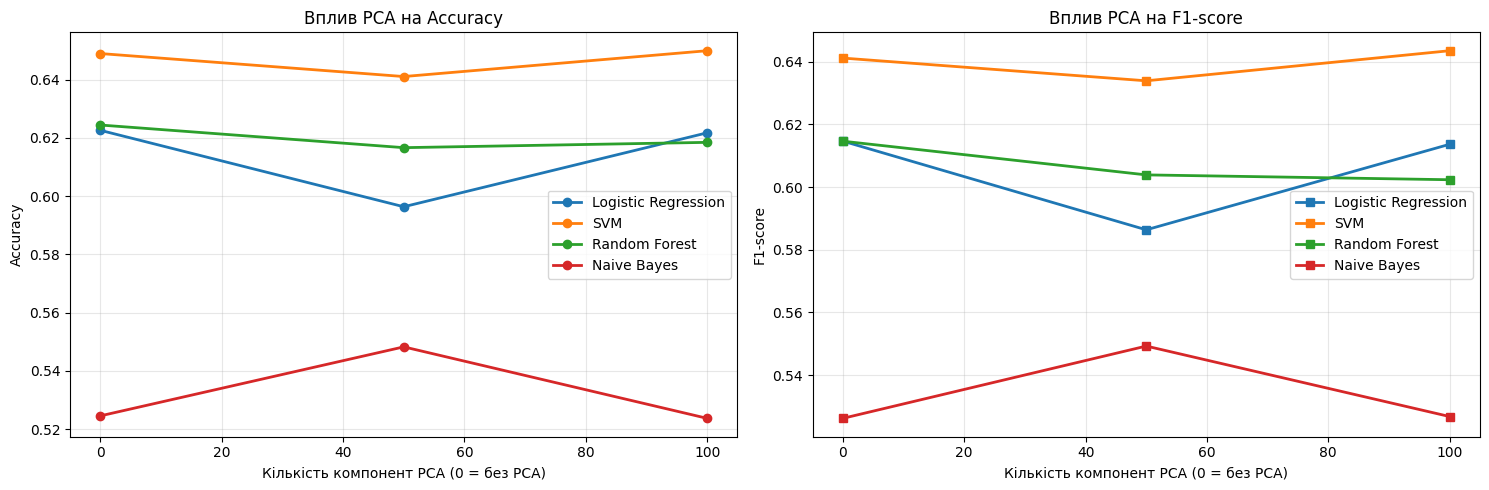

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pca_values = [0] + pca_components

for model_name in models.keys():
    accuracies = [results_no_pca[model_name]['accuracy']]
    f1_scores = [results_no_pca[model_name]['f1']]
    
    for n_comp in pca_components:
        accuracies.append(results_with_pca[n_comp][model_name]['accuracy'])
        f1_scores.append(results_with_pca[n_comp][model_name]['f1'])
    
    axes[0].plot(pca_values, accuracies, marker='o', label=model_name, linewidth=2)
    axes[1].plot(pca_values, f1_scores, marker='s', label=model_name, linewidth=2)

axes[0].set_xlabel('Кількість компонент PCA (0 = без PCA)')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Вплив PCA на Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Кількість компонент PCA (0 = без PCA)')
axes[1].set_ylabel('F1-score')
axes[1].set_title('Вплив PCA на F1-score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Визначення найкращої моделі

In [16]:
all_results = []

for model_name in models.keys():
    all_results.append({
        'Model': model_name,
        'PCA': 'No PCA',
        'Accuracy': results_no_pca[model_name]['accuracy'],
        'F1': results_no_pca[model_name]['f1']
    })
    
    for n_comp in pca_components:
        all_results.append({
            'Model': model_name,
            'PCA': f'PCA-{n_comp}',
            'Accuracy': results_with_pca[n_comp][model_name]['accuracy'],
            'F1': results_with_pca[n_comp][model_name]['f1']
        })

all_results_df = pd.DataFrame(all_results)
best_model = all_results_df.loc[all_results_df['F1'].idxmax()]

print("Найкраща модель:")
print(f"Модель: {best_model['Model']}")
print(f"Конфігурація: {best_model['PCA']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-score: {best_model['F1']:.4f}")

Найкраща модель:
Модель: SVM
Конфігурація: PCA-100
Accuracy: 0.6499
F1-score: 0.6435


## 12. Confusion Matrix для найкращої моделі

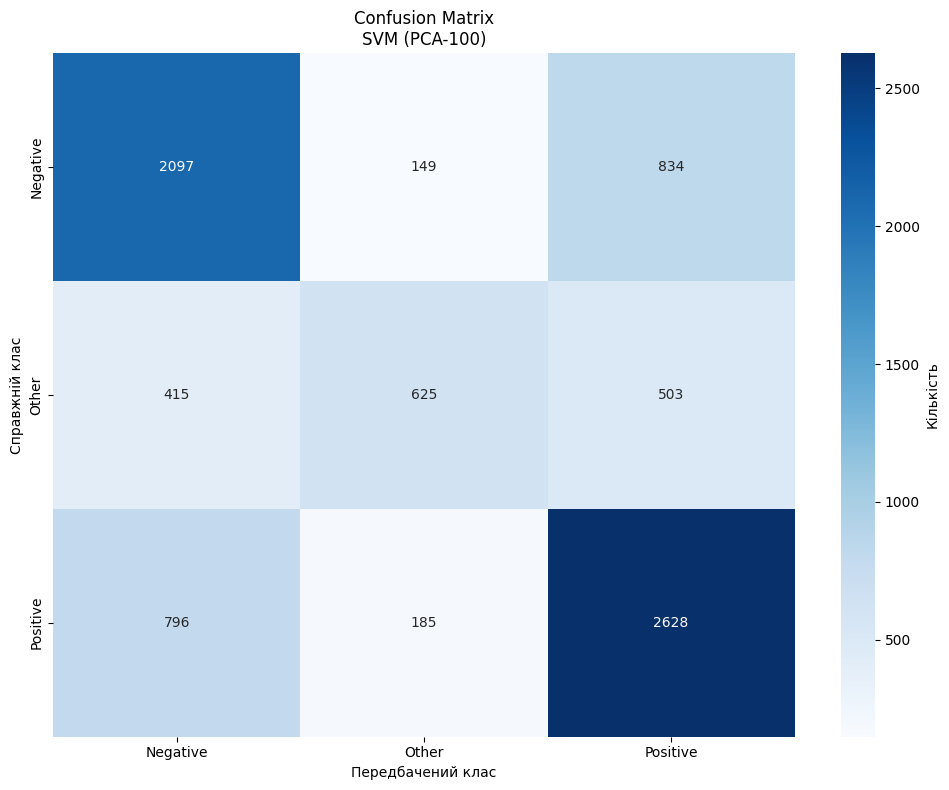

In [17]:
if best_model['PCA'] == 'No PCA':
    best_y_pred = results_no_pca[best_model['Model']]['y_pred']
else:
    n_comp = int(best_model['PCA'].split('-')[1])
    best_y_pred = results_with_pca[n_comp][best_model['Model']]['y_pred']

cm = confusion_matrix(y_test, best_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cbar_kws={'label': 'Кількість'})
plt.title(f'Confusion Matrix\n{best_model["Model"]} ({best_model["PCA"]})')
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.tight_layout()
plt.show()

## 13. Детальний звіт класифікації

In [18]:
print(f"Детальний звіт для {best_model['Model']} ({best_model['PCA']}):")
print("\n" + classification_report(y_test, best_y_pred, target_names=le.classes_))

Детальний звіт для SVM (PCA-100):

              precision    recall  f1-score   support

    Negative       0.63      0.68      0.66      3080
       Other       0.65      0.41      0.50      1543
    Positive       0.66      0.73      0.69      3609

    accuracy                           0.65      8232
   macro avg       0.65      0.60      0.62      8232
weighted avg       0.65      0.65      0.64      8232



## 14. Висновки

**Результати експерименту:**

1. **Найкраща модель:** визначається за найвищим F1-score серед усіх конфігурацій

2. **Вплив PCA:**
   - PCA зазвичай трохи зменшує точність через втрату інформації
   - Проте PCA значно прискорює навчання та передбачення
   - Баланс між точністю та швидкістю залежить від завдання

3. **Порівняння моделей:**
   - Logistic Regression та SVM показують стабільні результати
   - Random Forest менш чутливий до зниження розмірності
   - Naive Bayes працює швидше, але зазвичай з нижчою точністю

4. **Рекомендації:**
   - Для максимальної точності: використовуйте модель без PCA
   - Для швидкої класифікації: PCA-50 дає хороший баланс
   - Word2Vec добре захоплює семантику слів для класифікації тональності